<a href="https://colab.research.google.com/github/dphi-official/Data_Science_Bootcamp/blob/master/Week4/Model_Optimization_with_Random_Forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduction
The dataset used in this notebook is of '[IEEE-CIS Fraud Detection](https://www.kaggle.com/c/ieee-fraud-detection/data)'. This notebook will introduce you to class imbalance problem.

Data set link: [Fraud Dataset](https://drive.google.com/file/d/1q8SYcjOJULdSkETv5S_gd7xNq1GrBHAO/view)

#### Imbalanced Problem
Imbalanced classes are a common problem in machine learning classification where there are a disproportionate ratio of observations in each class. Class imbalance can be found in many different areas including medical diagnosis, spam filtering, and fraud detection.

#### Agenda
*  Loading Libraries
*  Loading Data
*  Getting Basic Idea About Data
*  Missing Values and Dealing with Missing Values
*  One Hot Encoding (Creating dummies for categorical columns)
*  Standardization / Normalization
*  Splitting the dataset into train and test data
*  Dealing with Imbalanced Data
    *  Generate Synthetic Samples



## Loading Libraries
All Python capabilities are not loaded to our working environment by default (even they are already installed in your system). So, we import each and every library that we want to use.

In data science, numpy and pandas are most commonly used libraries. Numpy is required for calculations like means, medians, square roots, etc. Pandas is used for data processin and data frames. We chose alias names for our libraries for the sake of our convenience (numpy --> np and pandas --> pd).

In [ ]:
import pandas as pd                  # A fundamental package for linear algebra and multidimensional arrays
import numpy as np                   # Data analysis and data manipulating tool
import random                        # Library to generate random numbers
from collections import Counter      # Collection is a Python module that implements specialized container datatypes providing 
                                     # alternatives to Python’s general purpose built-in containers, dict, list, set, and tuple.
                                     # Counter is a dict subclass for counting hashable objects
# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# To ignore warnings in the notebook
import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Loading Data
Pandas module is used for reading files. We have our data in '.csv' format. We will use 'read_csv()' function for loading the data.

**Disclaimer:** Loading fraud data might take time due to the nature of its size

In [ ]:
fraud_data = pd.read_csv("https://raw.githubusercontent.com/dphi-official/Imbalanced_classes/master/fraud_data.csv")

### Getting Basic Idea About Data

In [ ]:
fraud_data.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2994681,0,242834,25.000,H,9803,583.0,150.0,visa,226.0,credit,269.0,87.0,NaN,NaN,yahoo.com,NaN,1,1,0,0,0,1,0,1,0,1,1,0,1,1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,7.791666,0.791666,...,0.0,82050.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,NaN,-300.0,Found,Found,166.0,NaN,529.0,178.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,Mac OS X 10.12,firefox 56.0,24.0,1920x1080,match_status:2,T,F,T,T,desktop,rv:56.0
1,3557242,0,15123000,117.000,W,7919,194.0,150.0,mastercard,166.0,debit,181.0,87.0,483.0,NaN,gmail.com,NaN,1,4,0,0,0,1,0,0,3,0,3,0,4,1,63.0,35.0,1.0,4.0,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3327470,0,8378575,73.773,C,12778,500.0,185.0,mastercard,224.0,credit,284.0,60.0,NaN,NaN,hotmail.com,hotmail.com,1,3,0,1,0,1,1,0,0,0,2,2,3,1,54.0,54.0,35.0,54.0,35.0,54.0,35.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3118781,0,2607840,400.000,R,12316,548.0,150.0,visa,195.0,credit,441.0,87.0,NaN,371.0,anonymous.com,anonymous.com,1,1,0,1,0,1,0,1,0,1,1,0,1,1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-5.0,183599.0,NaN,NaN,6.0,-11.0,NaN,NaN,NaN,NaN,100.0,NotFound,49.0,-300.0,New,NotFound,166.0,15.0,352.0,280.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,iOS 10.3.3,mobile safari generic,32.0,1136x640,match_status:2,T,F,T,F,mobile,iOS Device
4,3459772,0,12226544,31.950,W,9002,453.0,150.0,visa,226.0,debit,264.0,87.0,10.0,NaN,yahoo.com,NaN,3,3,0,0,3,4,0,0,3,0,2,0,33,3,54.0,54.0,15.0,405.0,32.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
fraud_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59054 entries, 0 to 59053
Columns: 434 entries, TransactionID to DeviceInfo
dtypes: float64(385), int64(18), object(31)
memory usage: 195.5+ MB


There are 434 columns with 59054 observations.

In [ ]:
fraud_data.describe()

,TransactionID,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,dist2,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,...,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_13,id_14,id_17,id_18,id_19,id_20,id_21,id_22,id_24,id_25,id_26,id_32
count,5.905400e+04,59054.000000,5.905400e+04,59054.000000,59054.000000,58139.000000,58896.000000,58610.000000,52326.000000,52326.000000,23701.000000,3872.000000,59054.000000,59054.000000,59054.000000,59054.000000,59054.000000,59054.000000,59054.000000,59054.000000,59054.000000,59054.000000,59054.000000,59054.000000,59054.000000,59054.000000,58933.000000,31100.000000,32839.000000,42208.000000,28075.000000,7421.000000,3947.000000,7553.000000,7553.000000,51514.000000,30902.000000,6580.000000,6324.000000,6317.000000,...,8211.000000,8211.000000,8211.000000,8211.000000,8211.000000,8211.000000,8211.000000,8211.000000,8211.000000,8211.000000,8211.000000,8211.000000,8211.000000,8211.000000,8211.000000,8211.000000,8211.000000,14555.000000,14194.000000,6697.000000,6697.000000,13820.000000,13820.000000,525.000000,525.000000,7553.000000,7553.000000,14205.000000,12887.000000,7963.000000,14061.00000,4511.000000,14059.000000,14054.000000,525.000000,525.000000,487.000000,524.000000,525.000000,7715.000000
mean,3.282166e+06,0.033952,7.368220e+06,134.142888,9910.366360,362.438054,153.264551,199.104231,290.653939,86.806616,115.655837,215.529442,13.213212,14.233447,0.005571,3.673773,5.480120,8.574305,2.476784,4.551275,4.422173,4.642226,9.597893,3.551428,31.658753,7.955397,94.243548,168.784855,28.215689,139.992561,42.073375,70.105107,41.393970,145.864171,0.552242,124.267325,147.232800,54.019149,18.445130,57.257084,...,14.844477,10.334673,0.061259,0.891609,0.318232,0.367556,1.470710,0.857752,849.716295,1577.078680,1152.623919,12.852454,67.041535,34.014493,59.909633,171.761661,111.076848,-10.241498,174517.019938,0.048828,-0.054950,1.564110,-6.731766,13.460952,-38.022857,0.084337,-0.274196,99.753982,47.978273,-345.713927,189.89958,14.238750,351.767622,404.594777,385.257143,15.748571,12.739220,326.225191,148.794286,26.499028
std,1.702573e+05,0.181107,4.612063e+06,233.112295,4893.704524,157.360648,11.395609,41.296438,101.796538,2.639572,366.462377,506.824710,123.135469,142.344325,0.163114,63.702441,25.570422,66.567581,56.502781,87.486345,16.593728,87.825362,87.212257,79.301070,124.218136,46.514295,157.679479,177.314255,62.528194,190.990250,88.257774,142.669131,98.446942,233.615671,0.319701,183.034325,185.927214,123.116200,69.076225,134.707158,...,113.784292,78.037190,0.312194,4.115381,1.434882,1.684518,9.305046,4.987901,6698.443610,11954.433804,8490.237746,366.868543,566.486726,390.038930,657.909569,1144.071698,823.586157,14.412998,158198.544249,0.607971,0.659661,5.071657,16.586186,11.546822,24.980822,0.932670,2.668107,1.106252,11.914148,91.661528,30.34787,1.524658,141.600677,152.201538,213.565534,6.496154,2.275238,97.662855,31.168092,3.739140
min,2.987019e+06,0.000000,8.673000e+04,0.292000,1008.000000,100.000000,100.000000,100.000000,100.000000,13.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-90.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-33.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-100.000000,43.000000,-12.000000,-12.000000,-32.000000,-100.000000,-31.000000,-100.000000,-26.000000,-100.000000,90.000000,11.000000,-660.000000,100.00000,11.000000,100.000000,100.000000,114.000000,14.000000,11.000000,100.000000,100.000000,0.000000
25%,3.135748e+06,0.000000,3.074217e+06,42.950000,6019.000000,215.000000,150.000000,166.000000,204.000000,87.000000,3.0000

In [ ]:
# Taking a look at the target variable
fraud_data.isFraud.value_counts()

0    57049
1     2005
Name: isFraud, dtype: int64

We can notice, of 57049 observations / records only 2005 were fraud transactions.

In [ ]:
fraud_data.isFraud.value_counts(normalize = True)      # Normalize = True will find the proportion of fraud transaction and not fraud transaction 

0    0.966048
1    0.033952
Name: isFraud, dtype: float64

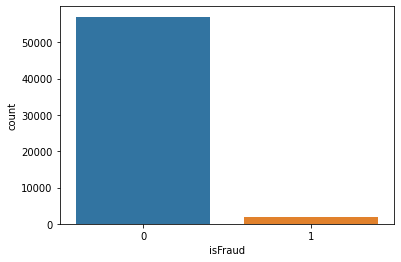

In [ ]:
# we can also use countplot form seaborn to plot the above information graphically.
sns.countplot(fraud_data.isFraud)

There are only 3% of the data which are fraud and the rest 97% are not fraud. This is clearly a class imbalance problem. In this notebook we will look to solve this type of problems.

### Missing values
Generally datasets always have some missing values. May be done during data collection, or due to some data validation rule.


In [ ]:
def miss_val_info(df):
  """
  This function will take a dataframe and calculates the frequency and percentage of missing values in each column.
  """
  missing_count = df.isnull().sum().sort_values(ascending = False)
  missing_percent = round(missing_count / len(df) * 100, 2)
  missing_info = pd.concat([missing_count, missing_percent], axis = 1, keys=['Missing Value Count','Percent of missing values'])
  return missing_info[missing_info['Missing Value Count'] != 0]


In [ ]:
miss_val_info(fraud_data)      # Display the frequency and percentage of data missing in each column

,Missing Value Count,Percent of missing values
id_24,58567,99.18
id_25,58530,99.11
id_27,58529,99.11
id_21,58529,99.11
id_22,58529,99.11
...,...,...
V309,3,0.01
V308,3,0.01
V307,3,0.01
V306,3,0.01


Out of 434 columns, 414 have some missing values.

### Dealing with Missing Values
*  Filling the missing values with right technique can change our results drastically. 
*  Also, there is no fixed rule of filling the missing values.
*  No method is perfect for filling the missing values. We need to use our common sense, our logic, or may need to see what works for that particular data set.

### Ways of dealing with missing values:

**Default value:** One can fill the missing value by default value on the basis of one's 1) understanding of variable, 2) context / data insight or 3) common sense / logic. 

**Deleting:** Suppose in our dataset we have too many missing values in

*  Column, we can drop the column
*  Row, drop the row. Usually we do this for a large enough dataset.

**Mean/Median/Mode - Imputation:** We fill missing values by mean or median or mode(i.e. maximum occuring value). Generally we use mean but if there are some outliers, we fill missing values with median. Mode is used to fill missing values for categorical column.

Eliminate columns with more than 20% missing values

In [ ]:
fraud_data = fraud_data[fraud_data.columns[fraud_data.isnull().mean() < 0.2]]

Here we will fill missing values with mean value for the numerical column.

In [ ]:
# filling missing values of numerical columns with mean value.
num_cols = fraud_data.select_dtypes(include=np.number).columns      # getting all the numerical columns

fraud_data[num_cols] = fraud_data[num_cols].fillna(fraud_data[num_cols].mean())   # fills the missing values with mean

Filling categorical columns with mode (i.e. maximum occuring element in the column)

In [ ]:
cat_cols = fraud_data.select_dtypes(include = 'object').columns    # getting all the categorical columns

fraud_data[cat_cols] = fraud_data[cat_cols].fillna(fraud_data[cat_cols].mode().iloc[0])  # fills the missing values with maximum occuring element in the column

In [ ]:
# Let's have a look if there still exist any missing values
miss_val_info(fraud_data)

,Missing Value Count,Percent of missing values


Notice, now we don't have any column with missing value.

### One Hot Encoding (Creating dummies for categorical columns)
In this strategy, each category value is converted into a new column and assigned a 1 or 0 (notation for true/false) value to the column. In Python there is a class 'OneHotEncoder' in 'sklearn.preprocessing' to do this task, but here we will use pandas function 'get_dummies()'. This get_dummies() does the same work as done by 'OneHotEncoder' form sklearn.preprocessing.

So, let's create dummy variables.

In [ ]:
fraud_data = pd.get_dummies(fraud_data, columns=cat_cols)    # earlier we have collected all the categorical columns in cat_cols

In [ ]:
fraud_data.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D10,D15,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,...,P_emaildomain_hotmail.com,P_emaildomain_hotmail.de,P_emaildomain_hotmail.es,P_emaildomain_hotmail.fr,P_emaildomain_icloud.com,P_emaildomain_juno.com,P_emaildomain_live.com,P_emaildomain_live.com.mx,P_emaildomain_live.fr,P_emaildomain_mac.com,P_emaildomain_mail.com,P_emaildomain_me.com,P_emaildomain_msn.com,P_emaildomain_netzero.com,P_emaildomain_netzero.net,P_emaildomain_optonline.net,P_emaildomain_outlook.com,P_emaildomain_outlook.es,P_emaildomain_prodigy.net.mx,P_emaildomain_protonmail.com,P_emaildomain_ptd.net,P_emaildomain_q.com,P_emaildomain_roadrunner.com,P_emaildomain_rocketmail.com,P_emaildomain_sbcglobal.net,P_emaildomain_sc.rr.com,P_emaildomain_servicios-ta.com,P_emaildomain_suddenlink.net,P_emaildomain_twc.com,P_emaildomain_verizon.net,P_emaildomain_web.de,P_emaildomain_windstream.net,P_emaildomain_yahoo.co.jp,P_emaildomain_yahoo.co.uk,P_emaildomain_yahoo.com,P_emaildomain_yahoo.com.mx,P_emaildomain_yahoo.de,P_emaildomain_yahoo.es,P_emaildomain_yahoo.fr,P_emaildomain_ymail.com
0,2994681,0,242834,25.000,9803,583.0,150.0,226.0,269.0,87.0,1,1,0,0,0,1,0,1,0,1,1,0,1,1,0.0,124.267325,163.966616,0.55965,0.597624,0.999398,0.124619,0.125551,0.137374,0.13883,0.814731,0.845542,0.133239,0.135394,1.035702,1.058825,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,3557242,0,15123000,117.000,7919,194.0,150.0,166.0,181.0,87.0,1,4,0,0,0,1,0,0,3,0,3,0,4,1,63.0,4.000000,4.000000,1.00000,1.000000,1.000000,0.000000,0.000000,0.000000,0.00000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3327470,0,8378575,73.773,12778,500.0,185.0,224.0,284.0,60.0,1,3,0,1,0,1,1,0,0,0,2,2,3,1,54.0,0.000000,54.000000,0.00000,0.000000,1.000000,1.000000,1.000000,0.000000,0.00000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,3118781,0,2607840,400.000,12316,548.0,150.0,195.0,441.0,87.0,1,1,0,1,0,1,0,1,0,1,1,0,1,1,0.0,124.267325,163.966616,0.55965,0.597624,0.999398,0.124619,0.125551,0.137374,0.13883,0.814731,0.845542,0.133239,0.135394,1.035702,1.058825,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,3459772,0,12226544,31.950,9002,453.0,150.0,226.0,264.0,87.0,3,3,0,0,3,4,0,0,3,0,2,0,33,3,54.0,71.000000,620.000000,1.00000,1.000000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


If you notice, a lot of dummy variables are created like; **P_emaildomain_hotmail.com, P_emaildomain_hotmail.de,** etc.

#### Separate Input Features and Output Features

In [ ]:
# Separate input features and output feature
X = fraud_data.drop(columns = ['isFraud'])       # input features
Y = fraud_data.isFraud      # output feature

from sklearn.model_selection import train_test_split

# Split randomly into 70% train data and 30% test data
X_train, X_Test, Y_train, Y_Test = train_test_split(X, Y, test_size = 0.3, random_state = 123)

# Dealing with Imbalanced Data
Most machine learning algorithms work best when the number of samples in each class are about equal. This is because most algorithms are designed to maximize accuracy and reduce error.


3. **Generate Synthetic Samples:** Here we will use imblearn’s SMOTE or Synthetic Minority Oversampling Technique. SMOTE uses a nearest neighbors algorithm to generate new and synthetic data we can use for training our model.

Again, it’s important to generate the new samples only in the training set to ensure our model generalizes well to unseen data.

In [ ]:
# import SMOTE 
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state = 25, ratio = 1.0)   # again we are eqalizing both the classes

In [ ]:
# fit the sampling
X_train, Y_train = sm.fit_sample(X_train, Y_train)

In [ ]:
np.unique(Y_train, return_counts=True)

(array([0, 1]), array([39944, 39944]))

The count of both the classes are equal.

### Building Random Forest Model
A Random Forest 🌲🌲🌲 is actually just a bunch of Decision Trees 🌲 bundled together (ohhhhh that’s why it’s called a forest). In this notebook we will learn how to build Random Forest Model.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(criterion='entropy')

In [ ]:
rfc.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
rfc.score(X_Test, Y_Test)

0.9753908675283626

### Feature Selection
Feature selection is the process of reducing the number of input variables when developing a predictive model.

It is desirable to reduce the number of input variables to both reduce the computational cost of modeling and, in some cases, to improve the performance of the model.

Here we are using 'slectKBest' from 'sklearn.feature_selection' which selects features according to the k highest scores. It takes two parameters:

* **score_func:** **callable**

  Function taking two arrays X and y, and returning a pair of arrays (scores, pvalues) or a single array with scores. Default is f_classif (see below “See also”). The default function only works with classification tasks.

* **k:  optional, default=10**
  
  Number of top features to select.


When we have numerical features and categorical output we can use 'f_classif' from 'sklearn.feature_selection'.

Further reading about feature selection: https://machinelearningmastery.com/feature-selection-with-real-and-categorical-data/



In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif

In [ ]:
selector = SelectKBest(f_classif, k=10)     # Let's say we select 10 best features

In [ ]:
X_new = selector.fit_transform(X, Y)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X_new, Y, test_size = 0.2, random_state = 42)

In [ ]:
rfc.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
rfc.score(X_test, Y_test)

0.969265938531877

**Note:** Obviously we can notice there is 0.7% decrease in accuracy score. The point to note is that we had got 97.5% accuracy with 249 features, then after that we selected only 10 features of 249 features and still able to get 96.9% accurate results. The conclusion is that we have reduced a lot of computational complexities which is very good as our aim is not only to increase the performance of the model at any cost but also to reduce the computational complexity of our model.

### Cross - Validation
Usually, our data is divided into Train and Test Sets. The Train set is further divided into Train and Validation set.

The Validation Set helps us in selecting good parameters/tune the parameters for our model.

In [ ]:
# We will use here k - fold cross validation technique
from sklearn.model_selection import cross_validate

In [ ]:
cv_results = cross_validate(rfc, X_new, Y, cv=10, scoring=["accuracy", "precision", "recall"])
cv_results

{'fit_time': array([1.53913021, 1.56077433, 1.57155609, 1.60067868, 1.6161437 ,
        1.58456111, 1.54124928, 1.52417064, 1.50520635, 1.52491522]),
 'score_time': array([0.05374193, 0.05819058, 0.05322051, 0.05408406, 0.05415249,
        0.05401015, 0.05401635, 0.0528028 , 0.05400944, 0.05233979]),
 'test_accuracy': array([0.96918388, 0.96867592, 0.96952252, 0.96867592, 0.96765453,
        0.96900931, 0.96816257, 0.96867062, 0.96985605, 0.96900931]),
 'test_precision': array([0.85185185, 0.78571429, 0.81818182, 0.80769231, 0.62857143,
        0.75757576, 0.7       , 0.71428571, 0.78947368, 0.8       ]),
 'test_recall': array([0.11442786, 0.10945274, 0.13432836, 0.10447761, 0.11      ,
        0.125     , 0.105     , 0.125     , 0.15      , 0.11940299])}

In [ ]:
print("Accuracy: ", cv_results["test_accuracy"].mean())

Accuracy:  0.968842065059342


Even with cross validation we are getting approx 96.9% of accurate results.

### Hyper parameter tunning
Hyperparameters are important parts of the ML model and can make the model gold or trash. Here we have discussed one of the popular hyperparameter tunning method i.e. using Grid Search CV.

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()

To know about different parameters of random forest visit here: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [ ]:
# Different parameters in random forest

criterion = ['gini', 'entropy']        # what criteria to consider

n_estimators = [100, 200, 300]       # Number of trees in random forest

max_features = ['auto', 'sqrt']       # Number of features to consider at every split

max_depth = [10, 20]      # Maximum number of levels in tree. Hope you remember linspace function from numpy session

max_depth.append(None)     # also appendin 'None' in max_depth i.e. no maximum depth to be considered.

params = {'criterion': criterion,
          'n_estimators': n_estimators,
          'max_features': max_features,
          'max_depth': max_depth}


In [ ]:
params

{'criterion': ['gini', 'entropy'],
 'max_depth': [10, 20, None],
 'max_features': ['auto', 'sqrt'],
 'n_estimators': [100, 200, 300]}

In [ ]:
gs = GridSearchCV(rfc, param_grid=params, n_jobs=2)

In [ ]:
gs.fit(X_train, Y_train)    # this will take a lot of time to execute; have some patience

GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              ra

In [ ]:
gs.best_params_

{'criterion': 'gini',
 'max_depth': 10,
 'max_features': 'sqrt',
 'n_estimators': 100}

In [ ]:
gs.best_score_

0.968418616846677

In [ ]:
gs.score(X_test, Y_test)

0.9689272711878757

**Conclusion**
*  We observed that the dataset contained missing values. We removed some columns and filled missing values for numerical column with mean and categorical column with mode (i.e. the maximum occuring value).
*  We observed that the dataset was imblanced. We used 'SMOTE' to generate new data to deal with the problem of imbalanced data.
*  We build Random Forest model, got accuracy score of 97.53%.
*  Then we selected only 10 most important features using selectKBest and f_classif. Here the model complexity is reduced a lot (which is very good) with very little decrease in accuracy
*  Cross Validation and Hyper parameter tunning gave nearly 96.8% of accurate results which is not bad. Most of the times the default values for hyper parameters of the models are same that we get through the hyper parameter tunning. That's the reason there is not much difference in normal model and tunned model.

References:
1. [Dealing with Imbalanced Data by Tara Boyle](https://towardsdatascience.com/methods-for-dealing-with-imbalanced-data-5b761be45a18)
2. [Data Pre-processing - Handling missing values and dealing with class imbalance by Bharat Ram Ammu](https://www.youtube.com/watch?v=vksQx1JNo8Y)
3. https://www.kaggle.com/drgilermo/a-tutorial-for-complete-beginners
4. https://machinelearningmastery.com/feature-selection-with-real-and-categorical-data/